In [9]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

In [10]:
df1 = pd.read_csv('googletrends2.csv')

non_zero_columns = df1.loc[:, (df1 != 0).any(axis=0)]
gtrend_languages = [col for col in non_zero_columns.columns if col != 'Month']  
num2 = len(gtrend_languages)

df=df1['Python']

In [11]:
model = pm.auto_arima(df, seasonal=False, stepwise=True, trace=True)

print(f"Best p: {model.order[0]}")
print(f"Best d: {model.order[1]}")
print(f"Best q: {model.order[2]}")

p = model.order[0]
d = model.order[1]
q = model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=778.806, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=776.251, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=772.897, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=777.525, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=771.099, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=772.585, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=772.291, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=770.347, Time=0.52 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=772.325, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=774.057, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=770.535, Time=0.39 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 5.100 seconds
Best p: 0
Best d: 1
Best q: 2


In [12]:
df = df.dropna()
df = df.astype(float)

arima_model = ARIMA(df, order=(p,d,q))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Python   No. Observations:                  112
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -382.268
Date:                Thu, 14 Nov 2024   AIC                            770.535
Time:                        10:10:42   BIC                            778.664
Sample:                             0   HQIC                           773.833
                                - 112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2634      0.085     -3.114      0.002      -0.429      -0.098
ma.L2         -0.1938      0.062     -3.115      0.002      -0.316      -0.072
sigma2        57.2896      4.935     11.608      0.0

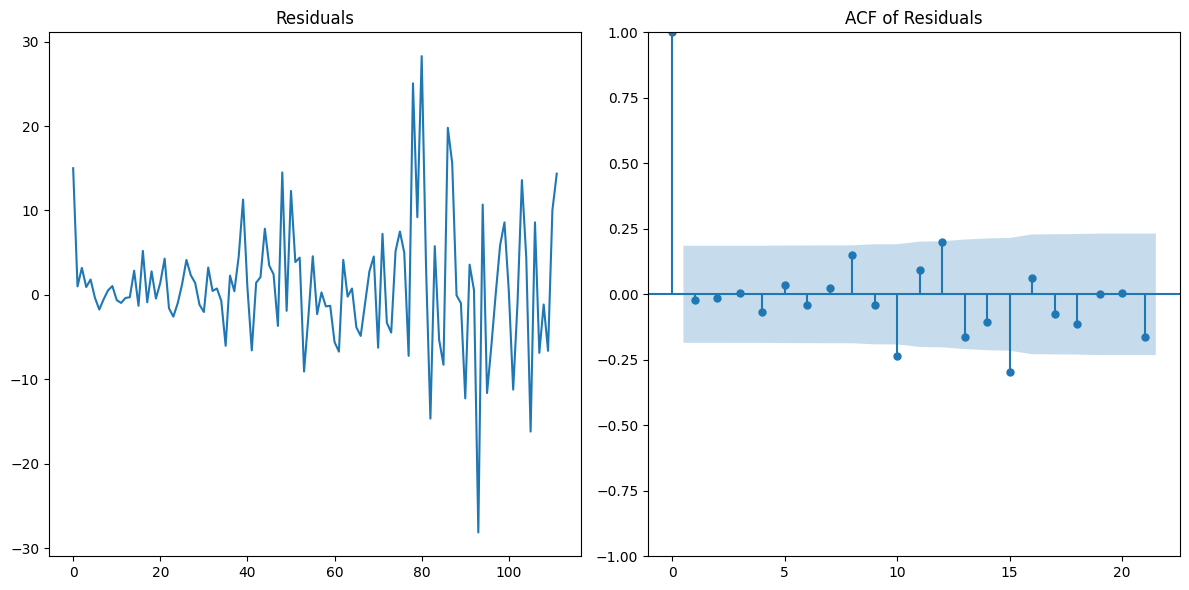

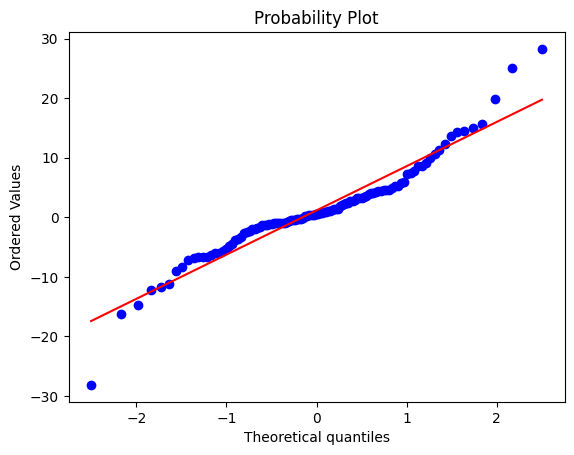

In [13]:
residuals = model.resid
plt.figure(figsize=(12, 6))

# Residual plot
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals')

# ACF of residuals
plt.subplot(1, 2, 2)
plot_acf(residuals, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()


In [14]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

arima_model = ARIMA(train, order=(1,1,1))
model = arima_model.fit()

forecast = model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 18.398351761803404, MSE: 421.02328398409276, RMSE: 20.51885191681281


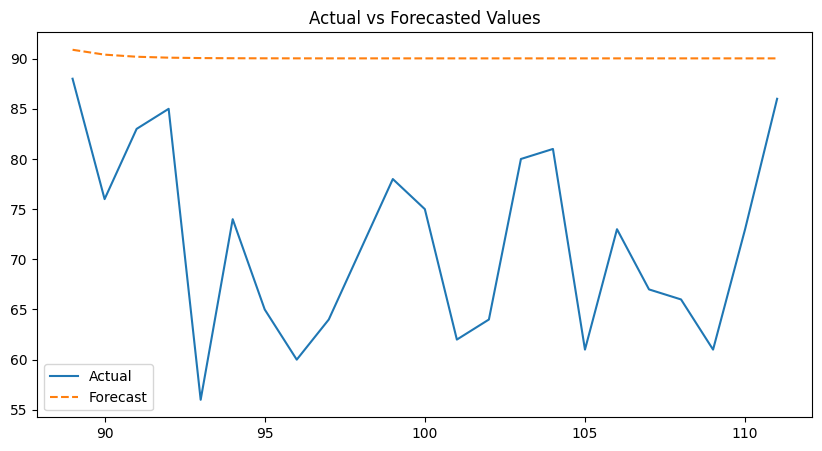

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("Actual vs Forecasted Values")
plt.show()


In [16]:
di = {}
di['language'] = []
di['mae'] = []
di['mse'] = []
di['rmse'] = []


for language in gtrend_languages:
    df = df1[language]

    tscv = TimeSeriesSplit(n_splits=10)
    
    fold_mae = []
    fold_mse = []
    fold_rmse = []

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        
        model = pm.auto_arima(train, seasonal=False, stepwise=True, trace=False)
        p, d, q = model.order
        
        arima_model = ARIMA(train, order=(p, d, q))
        model = arima_model.fit()

        forecast = model.forecast(steps=len(test))

        mae = mean_absolute_error(test, forecast)
        mse = mean_squared_error(test, forecast)
        rmse = np.sqrt(mse)

        fold_mae.append(mae)
        fold_mse.append(mse)
        fold_rmse.append(rmse)

    avg_mae = np.mean(fold_mae)
    avg_mse = np.mean(fold_mse)
    avg_rmse = np.mean(fold_rmse)

    print(f'Language: {language}')
    print(f"Average MAE: {avg_mae}, Average MSE: {avg_mse}, Average RMSE: {avg_rmse}")
    print()

    di['language'].append(language)
    di['mae'].append(avg_mae)
    di['mse'].append(avg_mse)
    di['rmse'].append(avg_rmse)

df_res = pd.DataFrame.from_dict(di)
df_res.to_csv('result_arima.csv', index=False)

Language: Java
Average MAE: 5.863698386251714, Average MSE: 76.66876769901721, Average RMSE: 6.5030083359217015

Language: JavaScript
Average MAE: 2.1337078397068456, Average MSE: 10.439896769999724, Average RMSE: 2.6569266320122504

Language: Node.js
Average MAE: 0.472351129385963, Average MSE: 0.4351778570000577, Average RMSE: 0.5789927706496029

Language: PHP
Average MAE: 3.1441241229993877, Average MSE: 16.83037383324226, Average RMSE: 3.657730166813652

Language: Visual Basic
Average MAE: 6.79130564680636, Average MSE: 101.79274646945802, Average RMSE: 7.616099254512513

Language: MySQL
Average MAE: 9.148345058848406, Average MSE: 139.77375153649697, Average RMSE: 10.98494209927088



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Language: TypeScript
Average MAE: 1.0382074936829564, Average MSE: 2.475599986660977, Average RMSE: 1.2957157054726935



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Language: SQL
Average MAE: 9.421511952333404, Average MSE: 154.78415745971785, Average RMSE: 11.5200669358534

Language: PostgreSQL
Average MAE: 2.9976435326078255, Average MSE: 14.323008955420283, Average RMSE: 3.549234342340958



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Language: Python
Average MAE: 9.025606915727924, Average MSE: 171.09434822963425, Average RMSE: 11.188161125370721

Language: kernel
Average MAE: 5.6155967586513205, Average MSE: 53.566464968361814, Average RMSE: 6.455850990287256

Language: ASP.NET
Average MAE: 2.236506453738993, Average MSE: 8.07621546002113, Average RMSE: 2.516291750855147



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: C#
Average MAE: 7.632348012095326, Average MSE: 89.56182862645647, Average RMSE: 8.693125931126257



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\U

Language: JS++
Average MAE: 0.018210684356111978, Average MSE: 0.01011860057792068, Average RMSE: 0.03983313107121653

Language: C
Average MAE: 5.415315165444699, Average MSE: 52.2850095722343, Average RMSE: 6.662180025272322



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\U

Language: GraphQL
Average MAE: 0.08618207599683893, Average MSE: 0.06263184983291081, Average RMSE: 0.13447424542655376

Language: Go
Average MAE: 8.869021867626824, Average MSE: 198.59687581239828, Average RMSE: 11.301241531589245



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: Ada
Average MAE: 0.14412981810367073, Average MSE: 0.08351304484765489, Average RMSE: 0.19909667760204663

Language: Ruby
Average MAE: 0.6841296014533784, Average MSE: 0.8518287920208711, Average RMSE: 0.7946178754554978

Language: MariaDB
Average MAE: 11.157231842842345, Average MSE: 206.61494714834006, Average RMSE: 13.556102401226195

Language: Scheme
Average MAE: 0.19006753751815136, Average MSE: 0.1860099266473616, Average RMSE: 0.26779323898653185



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: Solidity
Average MAE: 4.059595802898658, Average MSE: 38.23675693501293, Average RMSE: 4.769842567887309



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Language: Kotlin
Average MAE: 1.9684633069120143, Average MSE: 7.97020964152196, Average RMSE: 2.376078856195624

Language: Perl
Average MAE: 0.41195711187943046, Average MSE: 0.32879693726274634, Average RMSE: 0.4985629045848622



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  w

Language: C++
Average MAE: 13.382720932817495, Average MSE: 253.50078967016475, Average RMSE: 15.801334187101997



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: Scratch
Average MAE: 8.504460322104205, Average MSE: 249.0484438781923, Average RMSE: 10.338101267774832

Language: R
Average MAE: 3.4182625262992885, Average MSE: 20.553901764102523, Average RMSE: 4.08656485002885



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\U

Language: Rust
Average MAE: 0.44039563055296166, Average MSE: 0.4909556039971458, Average RMSE: 0.5449602591747391



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

Language: Groovy
Average MAE: 0.4639085289233, Average MSE: 0.3142703580861469, Average RMSE: 0.5392253796250286

Language: Scala
Average MAE: 0.5929124651061273, Average MSE: 0.6589016122390576, Average RMSE: 0.7192665179500104



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

Language: MATLAB
Average MAE: 12.272658466931976, Average MSE: 248.37098661556473, Average RMSE: 14.790085311002684

Language: Apex
Average MAE: 0.026591498001551063, Average MSE: 0.0011737224280191033, Average RMSE: 0.026591498001551066



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: SQLite
Average MAE: 4.980156886316537, Average MSE: 37.80551684985069, Average RMSE: 5.869613834314427

Language: ECMAScript
Average MAE: 1.8860349884541467, Average MSE: 5.562667699883842, Average RMSE: 2.156302680211181

Language: Assembly
Average MAE: 13.166294447766461, Average MSE: 247.2875978586478, Average RMSE: 15.087543652522422

Language: PowerShell
Average MAE: 3.824728654546843, Average MSE: 24.59715901684326, Average RMSE: 4.632150674507148



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Language: Visual FoxPro
Average MAE: 3.1135494491039184, Average MSE: 26.36308998313758, Average RMSE: 3.5770810591798927

Language: FoxPRO
Average MAE: 1.079767574190495, Average MSE: 3.3719388764933655, Average RMSE: 1.3296154337195651

Language: UNITY
Average MAE: 5.302306183808895, Average MSE: 52.0291758663505, Average RMSE: 5.921731117174208

Language: Arduino
Average MAE: 9.541561082831725, Average MSE: 160.78862571818604, Average RMSE: 11.644254408829038



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: PowerBuilder
Average MAE: 0.1458248952231625, Average MSE: 0.09980375656348602, Average RMSE: 0.20332191280966877

Language: SRL
Average MAE: 0.4655002529048379, Average MSE: 0.35477978516996, Average RMSE: 0.5409751228598031

Language: Haskell
Average MAE: 3.0817495522098364, Average MSE: 18.036916274041722, Average RMSE: 4.037193036882034

Language: Objective-C
Average MAE: 4.207612627609325, Average MSE: 27.447903454648532, Average RMSE: 4.8649892690588965

Language: Sqlalchemy
Average MAE: 3.9620334824088395, Average MSE: 26.55724204422301, Average RMSE: 4.669294015595235



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Language: Erlang
Average MAE: 6.284298134620695, Average MSE: 169.44305511903843, Average RMSE: 9.432304212872697



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Language: Lisp
Average MAE: 3.1810401802234485, Average MSE: 21.07075531550351, Average RMSE: 3.586429273941493



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

Language: Lua
Average MAE: 4.8093194239594, Average MSE: 36.40368226095678, Average RMSE: 5.3710593700600215



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: VBA
Average MAE: 8.961492527995862, Average MSE: 123.93040226235048, Average RMSE: 10.863116132481725

Language: ActionScript
Average MAE: 2.5130139608820317, Average MSE: 10.350540053368656, Average RMSE: 2.9598028896724444



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\U

Language: Boo
Average MAE: 0.9986589714559603, Average MSE: 8.56315406044526, Average RMSE: 1.1078006941095522



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: Stata
Average MAE: 3.3139992865444556, Average MSE: 16.721747450649293, Average RMSE: 3.8747223927801913



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Language: DML
Average MAE: 12.569003322003754, Average MSE: 230.81380004055353, Average RMSE: 14.403008853270554



c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Language: Dockerfile
Average MAE: 3.2363850449370686, Average MSE: 23.28292933723967, Average RMSE: 4.137443119819201

Language: VBScript
Average MAE: 4.561418901530314, Average MSE: 34.112863434086584, Average RMSE: 5.267393180930037

